In [298]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests

In [299]:
API_KEY = "8b491b601812f2ddd75d2597"
API_BASE_URL = f"https://v6.exchangerate-api.com/v6/{API_KEY}/latest/USD"
USERS_DATASET_PATH = "./Datasets/users.csv"
PURCHASES_DATASET_PATH = "./Datasets/purchases.csv"
rates = requests.get(API_BASE_URL).json()['conversion_rates']

In [300]:
users = pd.read_csv(USERS_DATASET_PATH)
purchases = pd.read_csv(PURCHASES_DATASET_PATH)
purchases.head(5)

,user_id,SKU,AddedTime,Price,CurrencyISO
0,6192636,personal_offer_starter_pack,2023-01-31 13:16:55.991756+00:00,2.29,GBP
1,5954105,bundle_pack_1,2023-01-06 19:20:33.631714+00:00,1.79,EUR
2,5954105,coin_pack_1,2023-01-07 15:56:47.792655+00:00,0.79,EUR
3,5903715,bundle_pack_1,2023-01-01 18:48:38.391356+00:00,1.99,USD
4,5984323,golden_ticket_season_pass,2023-01-11 21:13:47.161073+00:00,9.99,USD


# Preprocessing

## Normalizing Prices to USD

In [301]:
purchases["PriceUSD"] = purchases.apply(lambda row : row["Price"] / rates[row["CurrencyISO"]], axis=1)
purchases.head(5)

,user_id,SKU,AddedTime,Price,CurrencyISO,PriceUSD
0,6192636,personal_offer_starter_pack,2023-01-31 13:16:55.991756+00:00,2.29,GBP,2.783856
1,5954105,bundle_pack_1,2023-01-06 19:20:33.631714+00:00,1.79,EUR,1.905674
2,5954105,coin_pack_1,2023-01-07 15:56:47.792655+00:00,0.79,EUR,0.841052
3,5903715,bundle_pack_1,2023-01-01 18:48:38.391356+00:00,1.99,USD,1.990000
4,5984323,golden_ticket_season_pass,2023-01-11 21:13:47.161073+00:00,9.99,USD,9.990000


## Join Tables

In [302]:
df = pd.merge(users,purchases,on="user_id")
df

,user_id,registered_time,country_code,SKU,AddedTime,Price,CurrencyISO,PriceUSD
0,6192636,2023-01-30 16:12:02.731706+01:00,GB,personal_offer_starter_pack,2023-01-31 13:16:55.991756+00:00,2.29,GBP,2.783856
1,5954105,2023-01-05 20:33:54.584158+01:00,BE,bundle_pack_1,2023-01-06 19:20:33.631714+00:00,1.79,EUR,1.905674
2,5954105,2023-01-05 20:33:54.584158+01:00,BE,coin_pack_1,2023-01-07 15:56:47.792655+00:00,0.79,EUR,0.841052
3,5903715,2022-12-30 18:47:41.108888+01:00,US,bundle_pack_1,2023-01-01 18:48:38.391356+00:00,1.99,USD,1.990000
4,5984323,2023-01-09 18:57:06.353154+01:00,US,golden_ticket_season_pass,2023-01-11 21:13:47.161073+00:00,9.99,USD,9.990000
...,...,...,...,...,...,...,...,...
1399,5964679,2023-01-07 00:50:45.364926+01:00,US,bundle_pack_1,2023-02-01 13:13:43.680081+00:00,1.49,USD,1.490000
1400,5964679,2023-01-07 00:50:45.364926+01:00,US,coin_pack_1,2023-01-19 13:51:50.503887+00:00,0.99,USD,0.990000
1401,5964679,2023-01-07 00:50:45.364926+01:00,US,bundle_pack_1,2023-02-04 23:15:25.865344+00:00,1.49,USD,1.490000
1402,5964679,2023-01-07 00:50:45.364926+01:00,US,coin_pack_1,2023-01-20 15:43:32.899227+00:00,0.99,USD,0.990000


In [303]:
df["AddedTime"] = pd.to_datetime(df["AddedTime"])

# Data Visualization

## 1. Daily Sales

<Axes: xlabel='PriceUSD', ylabel='AddedTime'>

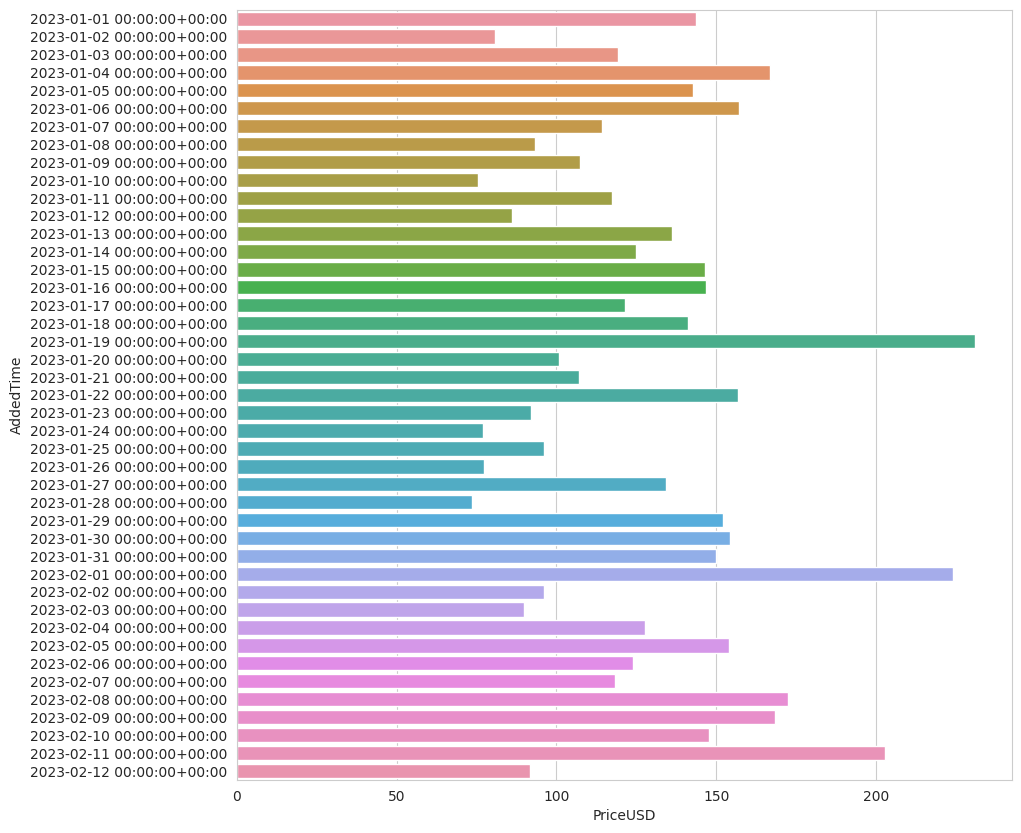

In [304]:
daily_sale = df.set_index("AddedTime").resample("D").sum("PriceUSD").reset_index()
plt.figure(figsize=(10,10))
sns.barplot(daily_sale, y="AddedTime",x="PriceUSD", orient="horizontal" )


##  2. Top 5 Sales Weekly

/tmp/ipykernel_1582/4189418465.py:2: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



<Axes: xlabel='PriceUSD', ylabel='AddedTime'>

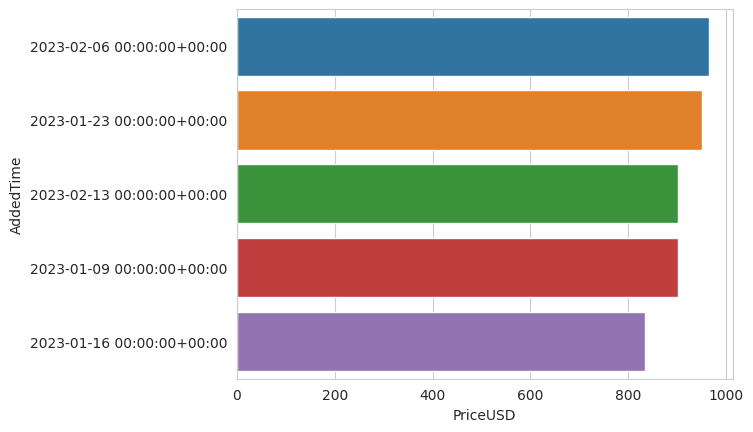

In [305]:
df["AddedTime"] = pd.to_datetime(df["AddedTime"])
weekly_sum = df.set_index("AddedTime").resample("W-MON").sum().nlargest(5, columns=["PriceUSD"]).reset_index()
sns.barplot(weekly_sum, x="PriceUSD", y="AddedTime", orient="horizontal")

## 3. Sales Per WeekDays

<Axes: >

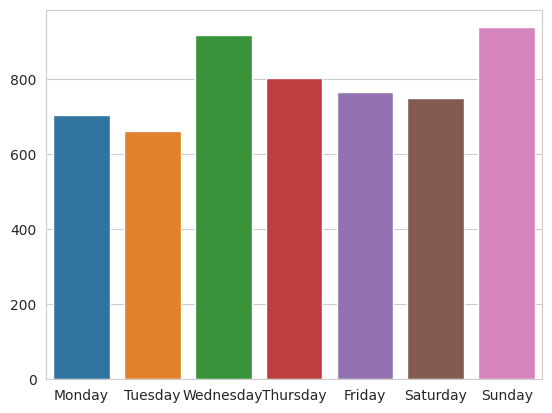

In [306]:
weekday_idx_sum = df.groupby(df["AddedTime"].dt.weekday).sum("PriceUSD")["PriceUSD"].to_dict()
weekday_map = {"0":  "Monday",
               "1" : "Tuesday",
               "2" : "Wednesday",
               "3" : "Thursday",
               "4" : "Friday",
               "5" : "Saturday",
               "6" : "Sunday"
               }
weekday_sum = {weekday_map[str(key)]: value for key,value in weekday_idx_sum.items()}
sns.barplot(x=list(weekday_sum.keys()), y=list(weekday_sum.values()))


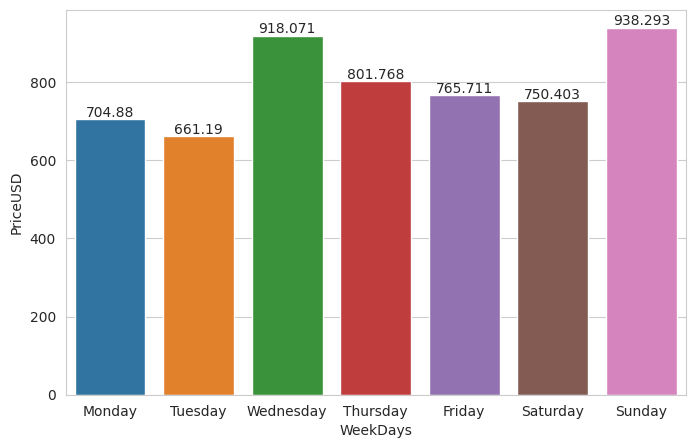

In [307]:
# A Better Way ;) 
weekday_idx_sum = df.groupby(df["AddedTime"].dt.weekday).sum("PriceUSD")
weekday_idx_sum["WeekDays"] = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
plt.figure(figsize=(8,5))
sns.set_style('whitegrid')
ax = sns.barplot(weekday_idx_sum , x="WeekDays" , y="PriceUSD")
for i in ax.containers:
    ax.bar_label(i,)


## 4. The Country of The Customer with Highest Purchase Value

In [308]:
user_id = df.groupby("user_id").sum("PriceUSD").nlargest(5,columns="PriceUSD").index[0]
df.loc[df["user_id"] == user_id , 'country_code'].values[0]

'US'

## 5. Count of Unique Buyers by Country

In [309]:
df.groupby("country_code")["user_id"].nunique().sort_values(ascending=False)

country_code
US    191
GB     37
AU     13
DE     13
CA     10
BE      4
PL      4
JP      3
NL      3
FR      3
DK      3
SE      2
ID      2
MY      1
RE      1
PH      1
TW      1
NO      1
SK      1
IT      1
MX      1
LK      1
IM      1
IL      1
HR      1
HK      1
GR      1
ES      1
CH      1
ZA      1
Name: user_id, dtype: int64

## 6. Top 5 Countries based on PriceUSD

In [310]:
df.groupby("country_code").sum("PriceUSD").nlargest(5,columns=["PriceUSD"])

,user_id,Price,PriceUSD
country_code,,,
US,4723735251,4226.72,4226.720000
GB,774079965,314.15,381.898857
AU,428101264,374.30,250.619351
DE,261850850,202.69,207.786784
CA,345601320,177.43,129.227968


## 7. Which Country has the best customers?

In [311]:
df.groupby("country_code").mean("PriceUSD").nlargest(5,columns=["PriceUSD"])

,user_id,Price,PriceUSD
country_code,,,
RE,6239061.0,10.990000,11.700202
IL,5935870.0,36.900000,10.045737
SE,5545225.5,69.000000,6.563240
NO,5374193.0,61.666667,5.756193
ES,5919498.0,4.990000,5.312467


## 9. World Map Distribution Count of Customers

In [312]:
import pycountry as pc

iso_alpha2_to_alpha3 = {country.alpha_2: country.alpha_3 for country in pc.countries}
country_count = df.rename(columns={"country_code":"iso_alpha"}).groupby("iso_alpha").size().reset_index(name="count")
# country_count["count"] = country_count["count"].apply(lambda x : [x])
country_count["iso_alpha"] = country_count["iso_alpha"].apply(lambda x : iso_alpha2_to_alpha3[x])
country_count

,iso_alpha,count
0,AUS,80
1,BEL,25
2,CAN,67
3,CHE,1
4,DEU,51
5,DNK,7
6,ESP,2
7,FRA,21
8,GBR,135
9,GRC,3


In [313]:
import plotly.express as px
import numpy as np
import pandas as pd

np.random.seed(12)
gapminder = px.data.gapminder().query("year==2007")


country_df=pd.merge(gapminder, country_count, how="left",  on='iso_alpha')

fig = px.choropleth(country_df, locations="iso_alpha",
                    color="count", 
                    hover_name="country", # column to add to hover information
                    color_continuous_scale=px.colors.sequential.YlOrRd)

fig.show()
